In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# building model 'josh' with gradient boosting

### considerations:
- heavily subset: 364,000 observations from 8 million merged
    - the subsetting... probably isn't random
    - a lot of times, cops can't get accurate demographic data on criminals (they can get it more often on victims, though)
        - so our data is 'when cops were able to record demographic data (age, sex, ethnicity) of both parties, and when they recorded data about weapons'
            - another consideration: **does NaN in the weapons category mean they were unarmed** or that no weapon could be determined properly?
                - it would be irresponsible of me to assume that cops erroneously recorded unarmed as NaN, especially because the #1 value in the column is 'unarmed'
- 'uniqueness' of row is a victim
    - so essentially, we're predicting what sort of crime someone was the victim of, rather than just predicting some crime that occurred
        - this is a tradeoff of merging victim data with crime & criminal data
        - we'll see if it's worth it
    
    

In [102]:
# load data
df = pd.read_csv('merged.csv')
df = df.drop(['Unnamed: 0', 'state_y', 'state'], axis=1)
df = df.rename(columns={
    'state_x':'state',
})

print('josh loaded')

josh loaded


In [30]:
df.columns

Index(['state', 'agency', 'case_number', 'UCR_code', 'attempt_or_complete',
       'DAC_1', 'location_type', 'weapon_type_1', 'bias_1', 'perp_seq_num',
       'perp_age', 'perp_sex', 'perp_race', 'perp_ethn', 'num_ori_matches_x',
       'victim_seq_num', 'ucr_1', 'vic_type', 'vic_age', 'vic_sex', 'vic_race',
       'vic_ethn', 'num_ori_matches_y'],
      dtype='object')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8505901 entries, 0 to 8505900
Data columns (total 23 columns):
state                  int64
agency                 object
case_number            object
UCR_code               object
attempt_or_complete    object
DAC_1                  object
location_type          int64
weapon_type_1          object
bias_1                 int64
perp_seq_num           int64
perp_age               float64
perp_sex               object
perp_race              object
perp_ethn              object
num_ori_matches_x      float64
victim_seq_num         int64
ucr_1                  object
vic_type               object
vic_age                object
vic_sex                object
vic_race               object
vic_ethn               object
num_ori_matches_y      float64
dtypes: float64(3), int64(5), object(15)
memory usage: 1.5+ GB


In [8]:
# vic_age is an object, let's numify it
c = 0
try:
    df['vic_age']=pd.to_numeric(df['vic_age'])
except:
    c += 1
print(c)

1


In [14]:
df.head(5)

,state,agency,case_number,UCR_code,attempt_or_complete,DAC_1,location_type,weapon_type_1,bias_1,perp_seq_num,...,perp_ethn,num_ori_matches_x,victim_seq_num,ucr_1,vic_type,vic_age,vic_sex,vic_race,vic_ethn,num_ori_matches_y
0,3,AR0010000,2-0QVS1MD I,13B,C,A,25,99,88,1,...,N,2.0,1,13B,I,30,F,W,N,1.0
1,3,AR0010000,2-BQ-51MD I,13B,C,N,20,99,88,1,...,N,1.0,1,13B,I,07,F,W,N,1.0
2,3,AR0010000,2-BQ-91MD I,13B,C,N,46,99,88,1,...,N,1.0,1,13B,I,30,M,W,N,1.0
3,3,AR0010000,1X-JP-H0HG1A,13B,C,N,15,99,88,1,...,U,2.0,1,13B,I,22,M,W,U,1.0
4,3,AR0010000,1X-MP-80HG1A,13B,C,N,25,99,88,1,...,H,1.0,1,13B,I,42,M,B,N,1.0


## variable questions


- is the victim's UCR (ucr_1) different from the crime's UCR_code?

In [20]:
t = df[df['UCR_code']==df['ucr_1']]
print(len(df),len(t))

364778 343600


- answer: maybe, yeah. so we'll keep it in
    - multiple victims for same crime, or multiple crimes for same victim

In [22]:
# target = df.UCR_code
# df.drop('UCR_code', axis=1, inplace=True)

In [78]:
target

869192                Arson
5730262               Drugs
7997383               Theft
7831761    Weapon_Violation
3506883               Drugs
                 ...       
64992                 Theft
4927026               Theft
4630907             Assault
912598              Assault
4498772             Assault
Name: UCR_code, Length: 5000, dtype: object

In [50]:
# target.hist()

In [ ]:
# d.head()

## Too many classification categories. let's bin

In [104]:

Assault = ['13A', '13B', '13C',]
Sex_Offense = ['11A', '11B', '11C', '11D', '36A', '36B',]
Financial_Fraud_Gambling = ['510', '250', '270', '210', '26A', '26B','26C', '26D', '26E', '39A', '39B', '39C', '39D']
Theft = ['220','23A','23B','23C','23D', '23E', '23F', '23G','23H', '240','120', '280']
Arson = ['200',]
Drugs = ['35A', '35B',]
Murder = ['09A']
Negligent_Manslaughter = ['09B']
Justifiable_Homicide = ['09C']
Abduction = ['100']
Obscene_Prostitution = ['370','40A','40B','40C',]
Weapon_Violation = ['520']

In [105]:
bins = {
    "Assault" : ['13A', '13B', '13C',],
    "Sex_Offense" : ['11A', '11B', '11C', '11D', '36A', '36B',],
    "Financial_Fraud_Gambling" : ['510', '250', '270', '210', '26A', '26B','26C', '26D', '26E', '39A', '39B', '39C', '39D'],
    "Theft" : ['220','23A','23B','23C','23D', '23E', '23F', '23G','23H', '240','120', '280'],
    "Arson" : ['200',],
    "Drugs" : ['35A', '35B',],
    "Murder" : ['09A'],
    "Negligent_Manslaughter" : ['09B'],
    "Justifiable_Homicide" : ['09C'],
    "Abduction" : ['100'],
    "Obscene_Prostitution" : ['370','40A','40B','40C',],
    "Weapon_Violation" : ['520'],
}

In [12]:
def cleaner(row): # if value in list, change value to that list's label
    entry = row['UCR_code']
    for key, value in bins.items():
        if entry in value:
            row['UCR_code'] = key
    return row


In [27]:
df.head()

,state,agency,case_number,attempt_or_complete,DAC_1,location_type,weapon_type_1,bias_1,perp_seq_num,perp_age,...,perp_ethn,num_ori_matches_x,victim_seq_num,ucr_1,vic_type,vic_age,vic_sex,vic_race,vic_ethn,num_ori_matches_y
0,3,AR0010000,2-0QVS1MD I,C,A,25,99,88,1,35.0,...,N,2.0,1,13B,I,30,F,W,N,1.0
1,3,AR0010000,2-BQ-51MD I,C,N,20,99,88,1,31.0,...,N,1.0,1,13B,I,07,F,W,N,1.0
2,3,AR0010000,2-BQ-91MD I,C,N,46,99,88,1,76.0,...,N,1.0,1,13B,I,30,M,W,N,1.0
3,3,AR0010000,1X-JP-H0HG1A,C,N,15,99,88,1,30.0,...,U,2.0,1,13B,I,22,M,W,U,1.0
4,3,AR0010000,1X-MP-80HG1A,C,N,25,99,88,1,65.0,...,H,1.0,1,13B,I,42,M,B,N,1.0


In [38]:
df['UCR_code'] = df['UCR_code'].apply(str)

In [52]:
# df.info()

In [53]:
len(df)
'''
We've got 8.5 million points. for time purposes, let's sample this down heavily.
'''

"\nWe've got 8.5 million points. for time purposes, let's sample this down heavily.\n"

In [ ]:
# d = df

In [44]:
full = d

In [54]:
store = df
len(store)

8505901

In [106]:
len(df)

8505901

In [107]:

df = df.dropna(axis=0)
len(df)

josh = df.sample(5000, random_state=1)
josh = josh.apply(lambda row: cleaner(row), axis=1)
print('UCR_code' in list(josh.columns))

True


In [108]:
josh_storage = josh

In [58]:
josh.to_csv('josh_sample_translated.csv')

In [15]:
df.to_csv('pre_translate.csv')

In [92]:
josh.columns

Index(['state', 'agency', 'case_number', 'UCR_code', 'attempt_or_complete',
       'DAC_1', 'location_type', 'weapon_type_1', 'bias_1', 'perp_seq_num',
       'perp_age', 'perp_sex', 'perp_race', 'perp_ethn', 'num_ori_matches_x',
       'victim_seq_num', 'ucr_1', 'vic_type', 'vic_age', 'vic_sex', 'vic_race',
       'vic_ethn', 'num_ori_matches_y'],
      dtype='object')

In [17]:
df.head()

,state,agency,case_number,UCR_code,attempt_or_complete,DAC_1,location_type,weapon_type_1,bias_1,perp_seq_num,...,perp_ethn,num_ori_matches_x,victim_seq_num,ucr_1,vic_type,vic_age,vic_sex,vic_race,vic_ethn,num_ori_matches_y
869192,6,CT0004400,830BRV5RSD N,Arson,C,N,20,NaN,88,1,...,NaN,1.0,3,200,I,37,F,W,N,NaN
5730262,41,TN0190100,3A1N1-KU7F7I,Drugs,C,N,20,NaN,88,1,...,N,1.0,1,35B,S,NaN,NaN,NaN,NaN,1.0
7997383,46,WA0320000,3A1N1-FP-G5X,Theft,C,N,3,NaN,88,1,...,NaN,1.0,1,23H,I,32,F,W,NaN,2.0
7831761,46,WA0270000,830GKVSMVF N,Weapon_Violation,C,N,22,11,88,2,...,NaN,NaN,1,220,B,NaN,NaN,NaN,NaN,2.0
3506883,33,ND0080100,0A1I0UO2JN1A,Drugs,C,N,13,NaN,88,1,...,NaN,1.0,1,240,I,36,M,W,N,2.0


In [18]:
df.to_csv('josh_translated.csv') # saving progress is good

In [109]:
df = josh

In [110]:
target = df['UCR_code']

In [20]:
with_tar = df
df = df.drop('UCR_code',axis=1)

In [32]:
target.astype(str)

869192                Arson
5730262               Drugs
7997383               Theft
7831761    Weapon_Violation
3506883               Drugs
                 ...       
64992                 Theft
4927026               Theft
4630907             Assault
912598              Assault
4498772             Assault
Name: UCR_code, Length: 5000, dtype: object

In [79]:
# from matplotlib import pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(20,12))
# sns.distplot(target)


# # target.hist()

In [ ]:
# samp = df.sample(1000, random_state = 1)
# tar = samp['UCR_code']
# tar.hist()

In [ ]:
# target.hist() 
# okay, hist is taking a while, we'll just run some stuff
# and when our R is bad we'll realize the data isn't normal at all and we should have ran the hist

## wait, my data isn't dummies yet
### that's going to take a looooong time to run. maybe kill my kernel.
- i'll test it tonight. maybe want to subsample down to n=5000 or so to make sure it works.
    - i don't like cutting data, but it'll be easy to plug it back in when it's done


In [48]:
df = pd.read_csv('josh_translated.csv')

In [ ]:
len()

In [96]:
josh = pd.get_dummies(josh)

In [97]:
josh.columns

Index(['state', 'location_type', 'bias_1', 'perp_seq_num', 'perp_age',
       'num_ori_matches_x', 'victim_seq_num', 'num_ori_matches_y',
       'agency_AR0010000', 'agency_AR0010100',
       ...
       'vic_sex_U', 'vic_race_A', 'vic_race_B', 'vic_race_I', 'vic_race_P',
       'vic_race_U', 'vic_race_W', 'vic_ethn_H', 'vic_ethn_N', 'vic_ethn_U'],
      dtype='object', length=6176)

In [89]:
josh.isna().any().sum()

3

In [98]:
df = josh

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.25)

In [65]:
# create classifiers
adaboost_clf = AdaBoostClassifier()
gbt_clf = GradientBoostingClassifier()

In [66]:
# training time
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [67]:
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [69]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='micro')
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.4026666666666667
F1-Score: 0.4026666666666667

Model: Gradient Boosted Trees
Accuracy: 0.4776
F1-Score: 0.4776

Testing Metrics
Model: AdaBoost
Accuracy: 0.4072
F1-Score: 0.4072

Model: Gradient Boosted Trees
Accuracy: 0.4024
F1-Score: 0.4024


confusion matrix

In [195]:
from sklearn import metrics

In [205]:
y_pred_class = 

In [197]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[  0   0   0   0   0   0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0 150   0]
 [  0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0   7   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0 257   0]
 [  0   0   0   0   0   0   0   0   0   0   0 179   0]
 [  0   0   0   0   0   0   0   0   0   0   0  86   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0  14   0]
 [  0   0   0   0   0   3   0   0   0   0   0 509   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30   0]]


In [203]:
types_of_crime = list(bins.keys())

In [223]:
df['UCR_code'].value_counts()

Assault                     4208
Sex_Offense                  357
Theft                        254
Weapon_Violation              92
Abduction                     59
Murder                        17
Financial_Fraud_Gambling       9
Negligent_Manslaughter         2
Justifiable_Homicide           1
64A                            1
Name: UCR_code, dtype: int64

In [ ]:
'''
more data
smote
XGboost
gridsearch
?
evaluation_metrics
accuracy might not be the best
all values being '''

In [206]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_class)
classes = types_of_crime

Confusion Matrix, without normalization
[[  0   0   0   0   0   0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0 150   0]
 [  0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0   7   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0 257   0]
 [  0   0   0   0   0   0   0   0   0   0   0 179   0]
 [  0   0   0   0   0   0   0   0   0   0   0  86   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0  14   0]
 [  0   0   0   0   0   3   0   0   0   0   0 509   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30   0]]


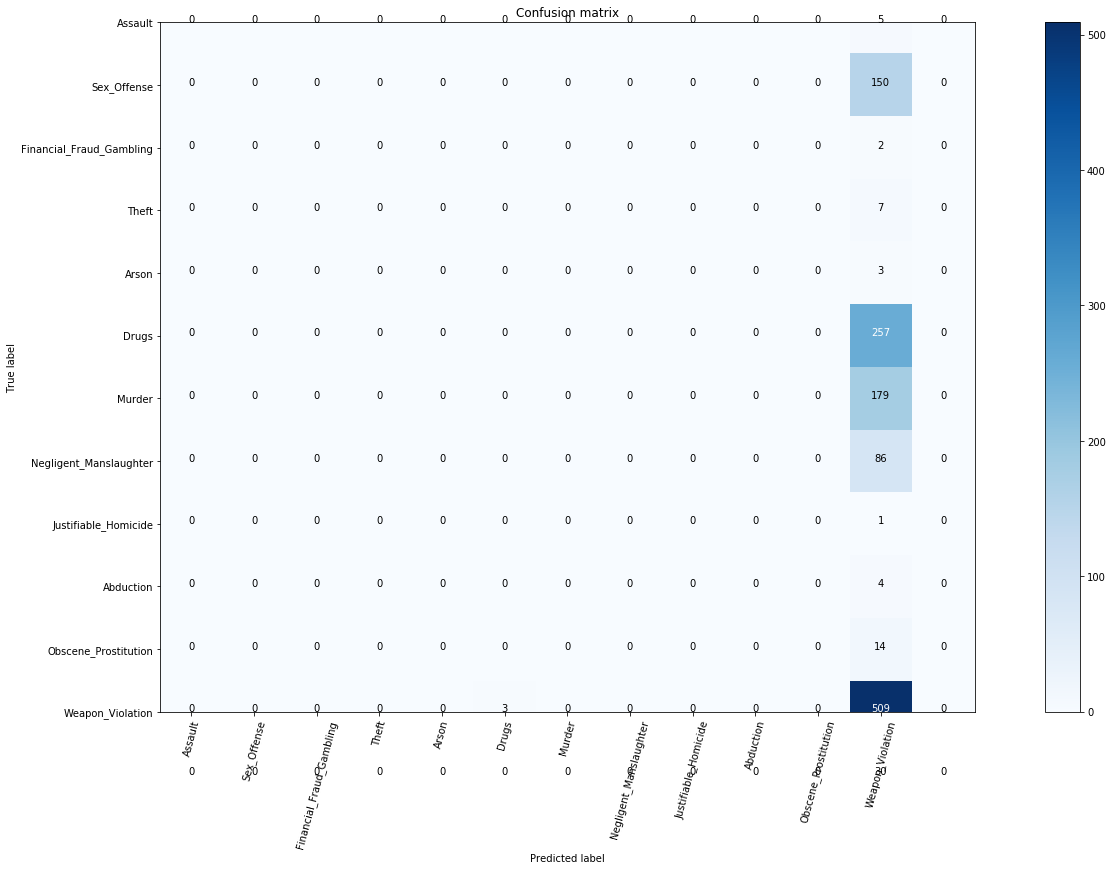

In [222]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    
    
#     Calculate chart area size
    leftmargin = 0.1 # inches
    rightmargin = 0.1 # inches
    categorysize = 0.1 # inches
    figwidth = leftmargin + rightmargin + (len(classes) * categorysize)           

    f = plt.figure(figsize=(20,12))

    # Create an axes instance and ajust the subplot size
    ax = f.add_subplot(111)
    ax.set_aspect(1)
    f.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth, top=0.94, bottom=0.9)

    res = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    
    
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

Confusion Matrix, without normalization
[[  0   0   0   0   0   0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0 150   0]
 [  0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0   7   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0 257   0]
 [  0   0   0   0   0   0   0   0   0   0   0 179   0]
 [  0   0   0   0   0   0   0   0   0   0   0  86   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0  14   0]
 [  0   0   0   0   0   3   0   0   0   0   0 509   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30   0]]


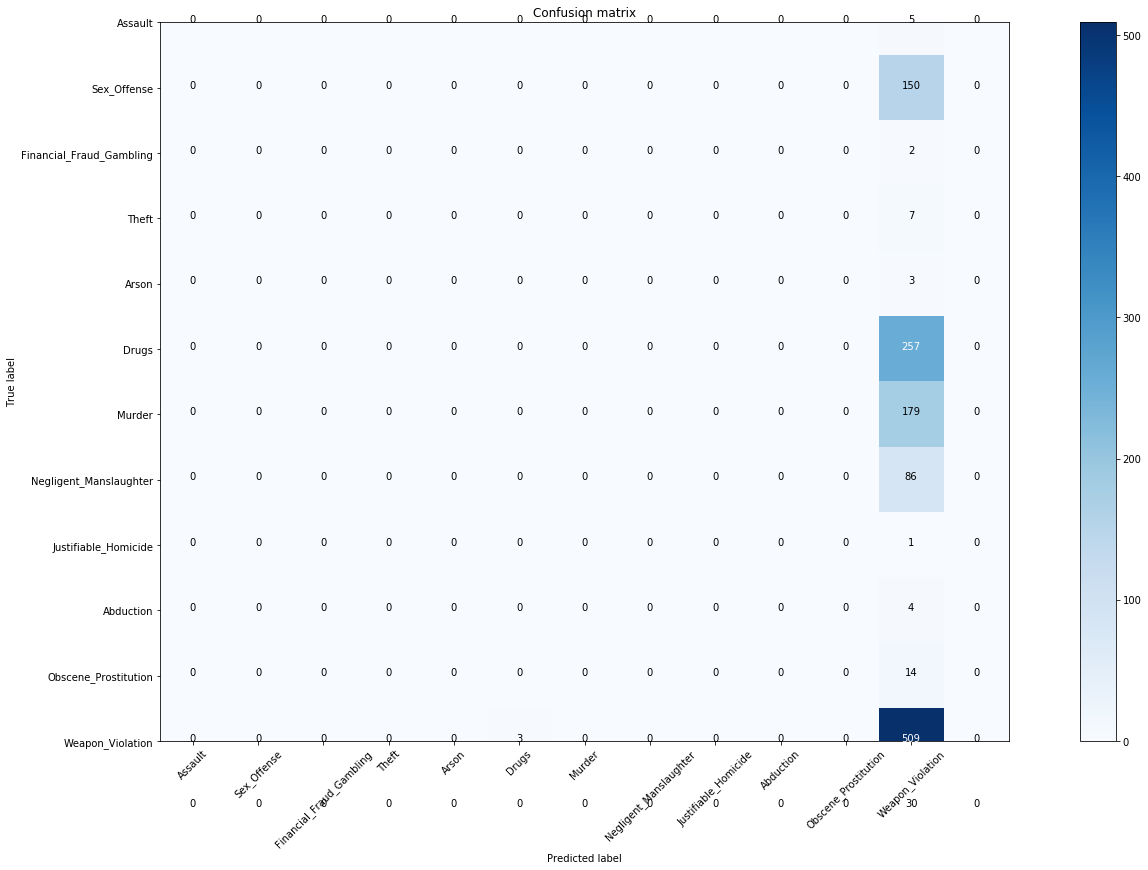

In [202]:
bins_list

['Assault',
 'Sex_Offense',
 'Financial_Fraud_Gambling',
 'Theft',
 'Arson',
 'Drugs',
 'Murder',
 'Negligent_Manslaughter',
 'Justifiable_Homicide',
 'Abduction',
 'Obscene_Prostitution',
 'Weapon_Violation']

In [198]:
bins

{'Assault': ['13A', '13B', '13C'],
 'Sex_Offense': ['11A', '11B', '11C', '11D', '36A', '36B'],
 'Financial_Fraud_Gambling': ['510',
  '250',
  '270',
  '210',
  '26A',
  '26B',
  '26C',
  '26D',
  '26E',
  '39A',
  '39B',
  '39C',
  '39D'],
 'Theft': ['220',
  '23A',
  '23B',
  '23C',
  '23D',
  '23E',
  '23F',
  '23G',
  '23H',
  '240',
  '120',
  '280'],
 'Arson': ['200'],
 'Drugs': ['35A', '35B'],
 'Murder': ['09A'],
 'Negligent_Manslaughter': ['09B'],
 'Justifiable_Homicide': ['09C'],
 'Abduction': ['100'],
 'Obscene_Prostitution': ['370', '40A', '40B', '40C'],
 'Weapon_Violation': ['520']}

In [71]:
print(len(bins), len(df.columns))

12 6176


In [193]:
df.isna().any().sum()

0

In [194]:
df.to_csv('5k_clean.csv')

## initial scores around .4
## we do .07 worse on the test than the train

that's not... terrible, considering we have 12 classifiers. Guessing the right one 40% of the time ain't bad.

Can we do better? of course, we only used 5k data points out of 364k (whilst dropping many rows to include less commonly recorded vars; perp_race was only recorded ~2/3 of the time)

also, we didn't normalize our data at all. though this is less of a consideration because our data is nearly all categorical.


## now it's time for actual EDA

let's try some PCA with on the 5000 sample set. might take a while with all our dummies

In [100]:
josh.columns

Index(['state', 'location_type', 'bias_1', 'perp_seq_num', 'perp_age',
       'num_ori_matches_x', 'victim_seq_num', 'num_ori_matches_y',
       'agency_AR0010000', 'agency_AR0010100',
       ...
       'vic_sex_U', 'vic_race_A', 'vic_race_B', 'vic_race_I', 'vic_race_P',
       'vic_race_U', 'vic_race_W', 'vic_ethn_H', 'vic_ethn_N', 'vic_ethn_U'],
      dtype='object', length=6176)

In [186]:
'UCR_code' in list(df.columns)

True

In [180]:
df2 = df

In [181]:
d.columns

Index(['state', 'location_type', 'bias_1', 'perp_seq_num', 'perp_age',
       'num_ori_matches_x', 'victim_seq_num', 'num_ori_matches_y',
       'agency_AR0010000', 'agency_AR0010100',
       ...
       'vic_sex_U', 'vic_race_A', 'vic_race_B', 'vic_race_I', 'vic_race_P',
       'vic_race_U', 'vic_race_W', 'vic_ethn_H', 'vic_ethn_N', 'vic_ethn_U'],
      dtype='object', length=6176)

In [187]:
d = pd.get_dummies(df)

In [188]:
'UCR_code' in list(d.columns)

False

In [183]:
d.columns

Index(['state', 'location_type', 'bias_1', 'perp_seq_num', 'perp_age',
       'num_ori_matches_x', 'victim_seq_num', 'num_ori_matches_y',
       'agency_AR0010000', 'agency_AR0010100',
       ...
       'vic_sex_U', 'vic_race_A', 'vic_race_B', 'vic_race_I', 'vic_race_P',
       'vic_race_U', 'vic_race_W', 'vic_ethn_H', 'vic_ethn_N', 'vic_ethn_U'],
      dtype='object', length=6176)

In [189]:
features = list(d.columns)
len(features)

6176

In [190]:
for st in features:
    if st[0]=='U':
        print(st)

UCR_code_64A
UCR_code_Abduction
UCR_code_Assault
UCR_code_Financial_Fraud_Gambling
UCR_code_Justifiable_Homicide
UCR_code_Murder
UCR_code_Negligent_Manslaughter
UCR_code_Sex_Offense
UCR_code_Theft
UCR_code_Weapon_Violation


In [133]:
features.remove('UCR_code')
len(features)

ValueError: list.remove(x): x not in list

In [80]:
storage = df

In [135]:
df2.columns

Index(['state', 'agency', 'case_number', 'UCR_code', 'attempt_or_complete',
       'DAC_1', 'location_type', 'weapon_type_1', 'bias_1', 'perp_seq_num',
       'perp_age', 'perp_sex', 'perp_race', 'perp_ethn', 'num_ori_matches_x',
       'victim_seq_num', 'ucr_1', 'vic_type', 'vic_age', 'vic_sex', 'vic_race',
       'vic_ethn', 'num_ori_matches_y'],
      dtype='object')

In [136]:
full = df2

In [138]:
target = full['UCR_code'] # store Y series


no_y = full.drop('UCR_code',axis=1) # exclude Y in dummy generation
dums = pd.get_dummies(full) # get dummies


In [139]:
# make list of X features including dummies
features = list(dums.columns)


In [147]:
g = df.append(target,ignore_index=True)
# df = pd.concat([df, s.to_frame().T])
g.columns

Index([              'state',              'agency',         'case_number',
                  'UCR_code', 'attempt_or_complete',               'DAC_1',
             'location_type',       'weapon_type_1',              'bias_1',
              'perp_seq_num',
       ...
                     8356361,               8357204,               8358027,
                     8358065,               8358186,               8359566,
                     8360951,               8361901,               8362401,
                     8390909],
      dtype='object', length=5023)

In [146]:
df.isna().any().sum()

0

In [148]:
g.isna().any().sum()

5023

In [151]:
g['UCR_code'].isna().sum()

1

#### trouble removing and re-appending Y column. let's just generate dummies with Y and then exclude Y in features

In [152]:
target = full['UCR_code'] # store Y series


# no_y = full.drop('UCR_code',axis=1) # exclude Y in dummy generation
dums = pd.get_dummies(full) # get dummies


In [162]:
full['UCR_code'].value_counts()

Assault                     4208
Sex_Offense                  357
Theft                        254
Weapon_Violation              92
Abduction                     59
Murder                        17
Financial_Fraud_Gambling       9
Negligent_Manslaughter         2
Justifiable_Homicide           1
64A                            1
Name: UCR_code, dtype: int64

In [171]:
features = list(dums.columns)
features = [st for st in features if st[0]!='U'] # take out Y + Y dummies


In [174]:
# features = ['cylinders', 'displacement', 'horsepower', 'weight',
#        'acceleration']
# preprocess the data 
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['UCR_code']].values

/Users/mark/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [175]:
x = StandardScaler().fit_transform(x)

/Users/mark/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/mark/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [176]:
# create principal components 
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2',
                                                                 'principal component 3','principal component 4',
                                                                 'principal component 5'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [177]:
pca.explained_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [178]:
pca.explained_variance_

AttributeError: 'PCA' object has no attribute 'explained_variance_'

In [ ]:
principalDf.iloc[:,:3].head()